# Customer Segmentation

We are given 9 datasets filled with clients' informations about their orders, locations etc.

We want our machine learning models to form clusters and assign each client to a group.

# Summary

* Data

Clustering :
* KMeans
* DBScan

# Library

In [14]:
# Data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Machine Learning library
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from boruta import BorutaPy as bp

# Other
from time import time
from warnings import filterwarnings
filterwarnings('ignore')

# Data

In this part we will :
* merge our 9 datasets into one
* remove seemingly useless columns
* remove outliers
* take care of missing values
* labelencode our columns

## Merging the datasets

In [2]:
orders_df = pd.read_csv("./resources/olist_orders_dataset.csv", encoding='utf-8', sep=',')
customers_df = pd.read_csv("./resources/olist_customers_dataset.csv", encoding='utf-8', sep=',')

data = customers_df.merge(orders_df, on= "customer_id")
data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25 00:00:00
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20 00:00:00
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02 00:00:00
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05 00:00:00


In [3]:
reviews_df = pd.read_csv("./resources/olist_order_reviews_dataset.csv", encoding='utf-8', sep=',')
data = data.merge(reviews_df, on= "order_id")
data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,02fc48a9efa3e3d0f1a8ea26507eeec3,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,5ad6695d76ee186dc473c42706984d87,5,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,059a801bb31f6aab2266e672cab87bc5,5,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,8490879d58d6c5d7773f2739a03f089a,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99219,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25 00:00:00,36e2cdbaa9f639b57c53b37ac798fee8,4,Recomendo,NaN,2018-04-14 00:00:00,2018-04-28 11:15:04
99220,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20 00:00:00,b273b431c3aedb4eed18643309652940,5,NaN,NaN,2018-04-12 00:00:00,2018-04-16 10:36:05
99221,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02 00:00:00,fa4f16891e6b2edd1354668d07f5648b,1,Chateada,Esperava qualidade no atendimento e estou tend...,2018-05-04 00:00:00,2018-05-08 01:41:07
99222,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05 00:00:00,0bcdc9e450ea500811a8d39ee993cd47,5,NaN,NaN,2017-11-17 00:00:00,2017-11-19 23:34:18


In [4]:
order_pay = pd.read_csv("./resources/olist_order_payments_dataset.csv", encoding='utf-8', sep=',')
data = data.merge(order_pay, on= "order_id")
data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1,credit_card,2,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,02fc48a9efa3e3d0f1a8ea26507eeec3,5,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29,1,credit_card,8,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,5ad6695d76ee186dc473c42706984d87,5,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,1,credit_card,7,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,059a801bb31f6aab2266e672cab87bc5,5,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,1,credit_card,1,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,8490879d58d6c5d7773f2739a03f089a,5,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,1,credit_card,8,252.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103672,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,...,36e2cdbaa9f639b57c53b37ac798fee8,4,Recomendo,NaN,2018-04-14 00:00:00,2018-04-28 11:15:04,1,credit_card,6,88.78
103673,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,...,b273b431c3aedb4eed18643309652940,5,NaN,NaN,2018-04-12 00:00:00,2018-04-16 10:36:05,1,credit_card,3,129.06
103674,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,...,fa4f16891e6b2edd1354668d07f5648b,1,Chateada,Esperava qualidade no atendimento e estou tend...,2018-05-04 00:00:00,2018-05-08 01:41:07,1,credit_card,5,56.04
103675,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,...,0bcdc9e450ea500811a8d39ee993cd47,5,NaN,NaN,2017-11-17 00:00:00,2017-11-19 23:34:18,1,credit_card,2,711.07


In [5]:
item = pd.read_csv("./resources/olist_order_items_dataset.csv", encoding='utf-8', sep=',')
data = data.merge(item, on= "order_id")
data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,1,credit_card,2,146.87,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,1,credit_card,8,335.48,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,1,credit_card,7,157.73,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,1,credit_card,1,173.30,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,1,credit_card,8,252.25,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117324,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,...,1,credit_card,6,88.78,1,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,2018-04-12 16:08:45,74.90,13.88
117325,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,...,1,credit_card,3,129.06,1,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,2018-04-10 08:35:12,114.90,14.16
117326,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,...,1,credit_card,5,56.04,1,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,2018-04-12 20:30:03,37.00,19.04
117327,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,...,1,credit_card,2,711.07,1,f819f0c84a64f02d3a5606ca95edd272,4869f7a5dfa277a7dca6462dcf3b52b2,2017-11-09 21:15:51,689.00,22.07


In [6]:
# Removing unneccessary features
data.pop('order_purchase_timestamp')
data.pop('order_approved_at')
data.pop('order_delivered_carrier_date')
data.pop('order_delivered_customer_date')
data.pop('order_estimated_delivery_date')
data.pop('review_comment_title')
data.pop('review_comment_message')
data.pop('review_creation_date')
data.pop('review_answer_timestamp')
data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,review_id,review_score,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,88b8b52d46df026a9d1ad2136a59b30b,4,1,credit_card,2,146.87,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,02fc48a9efa3e3d0f1a8ea26507eeec3,5,1,credit_card,8,335.48,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,5ad6695d76ee186dc473c42706984d87,5,1,credit_card,7,157.73,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,059a801bb31f6aab2266e672cab87bc5,5,1,credit_card,1,173.30,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,8490879d58d6c5d7773f2739a03f089a,5,1,credit_card,8,252.25,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117324,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,36e2cdbaa9f639b57c53b37ac798fee8,4,1,credit_card,6,88.78,1,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,2018-04-12 16:08:45,74.90,13.88
117325,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,b273b431c3aedb4eed18643309652940,5,1,credit_card,3,129.06,1,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,2018-04-10 08:35:12,114.90,14.16
117326,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,fa4f16891e6b2edd1354668d07f5648b,1,1,credit_card,5,56.04,1,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,2018-04-12 20:30:03,37.00,19.04
117327,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,0bcdc9e450ea500811a8d39ee993cd47,5,1,credit_card,2,711.07,1,f819f0c84a64f02d3a5606ca95edd272,4869f7a5dfa277a7dca6462dcf3b52b2,2017-11-09 21:15:51,689.00,22.07


In [7]:
data.drop_duplicates()
data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,review_id,review_score,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,88b8b52d46df026a9d1ad2136a59b30b,4,1,credit_card,2,146.87,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,02fc48a9efa3e3d0f1a8ea26507eeec3,5,1,credit_card,8,335.48,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,5ad6695d76ee186dc473c42706984d87,5,1,credit_card,7,157.73,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,059a801bb31f6aab2266e672cab87bc5,5,1,credit_card,1,173.30,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,8490879d58d6c5d7773f2739a03f089a,5,1,credit_card,8,252.25,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117324,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,36e2cdbaa9f639b57c53b37ac798fee8,4,1,credit_card,6,88.78,1,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,2018-04-12 16:08:45,74.90,13.88
117325,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,b273b431c3aedb4eed18643309652940,5,1,credit_card,3,129.06,1,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,2018-04-10 08:35:12,114.90,14.16
117326,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,fa4f16891e6b2edd1354668d07f5648b,1,1,credit_card,5,56.04,1,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,2018-04-12 20:30:03,37.00,19.04
117327,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,0bcdc9e450ea500811a8d39ee993cd47,5,1,credit_card,2,711.07,1,f819f0c84a64f02d3a5606ca95edd272,4869f7a5dfa277a7dca6462dcf3b52b2,2017-11-09 21:15:51,689.00,22.07


## Removing outliers

In [8]:
data.drop(data.index[(data["payment_value"] > 5000)], axis=0, inplace=True)
data.drop(data.index[(data["price"] > 5000)], axis=0, inplace=True)

## Missing Values

In [9]:
print("Percentage of missing values on each column :\n")
print(((data.isnull().sum()/data.shape[0])*100).sort_values(ascending=False))
data = data.dropna()

Percentage of missing values on each column :

customer_id                 0.0
payment_type                0.0
price                       0.0
shipping_limit_date         0.0
seller_id                   0.0
product_id                  0.0
order_item_id               0.0
payment_value               0.0
payment_installments        0.0
payment_sequential          0.0
customer_unique_id          0.0
review_score                0.0
review_id                   0.0
order_status                0.0
order_id                    0.0
customer_state              0.0
customer_city               0.0
customer_zip_code_prefix    0.0
freight_value               0.0
dtype: float64


We are not missing any values from the database.

## LabelEncoding

In [10]:
le = LabelEncoder()
le_count = 0

for col in data:
    if data[col].dtype == 'object':
        le.fit(data[col])
        data[col] = le.transform(data[col])
        le_count += 1
        print(col)
data.reset_index()
print('%d columns were label encoded.' % le_count)

customer_id
customer_unique_id
customer_city
customer_state
order_id
order_status
review_id
payment_type
product_id
seller_id
shipping_limit_date
11 columns were label encoded.


# Clustering

In [11]:
X = StandardScaler().fit_transform(data)
X

array([[-1.63561046,  0.08336188, -0.69183197, ..., -1.40729091,
         0.02655591,  0.11745045],
       [-1.39368873, -1.17906021, -0.84656551, ..., -0.03699699,
         0.93695179,  1.67349576],
       [-0.66551915, -1.65473957, -1.13596649, ...,  1.04684   ,
         0.1095412 , -0.1412579 ],
       ...,
       [-0.45750606,  1.43596745,  0.83928979, ...,  0.6450901 ,
        -0.46186391, -0.06219056],
       [-0.55760551, -0.16363534,  1.91143681, ..., -0.57394791,
         3.15729417,  0.12946868],
       [-1.19366662,  0.0627391 , -0.94997804, ..., -0.19403266,
        -0.5895891 , -0.77442919]])

# KMeans

## Finding k the number of clusters

### Elbow Method

In [12]:
wcss = []
for i in range(10, 45):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

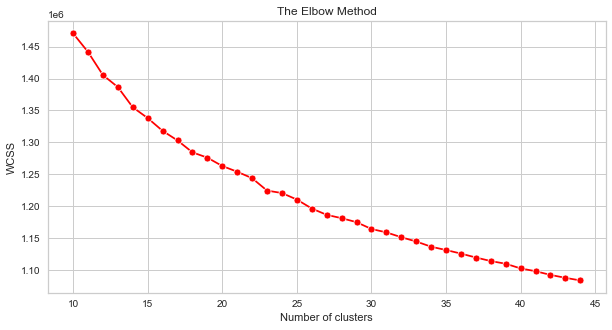

In [13]:
plt.figure(figsize=(10,5))
sns.lineplot(range(10, 45), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

There is an obvious elbow at 23, there is a smaller one at 30.

### Silhouette Plot

#### k = 23

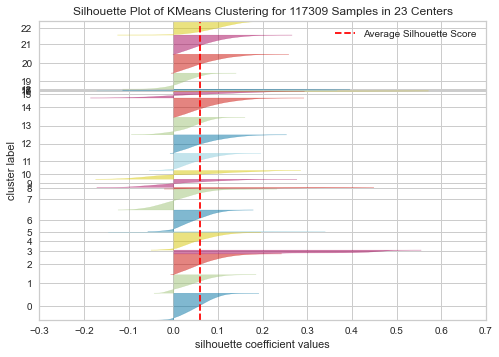

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 117309 Samples in 23 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [19]:
km = KMeans(n_clusters=23, init='k-means++', n_init=10, max_iter=100, random_state=42)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()

#### From 10 to 40 

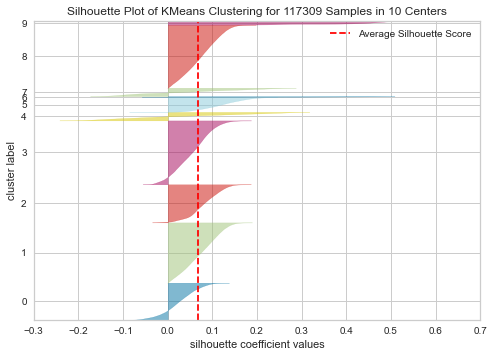

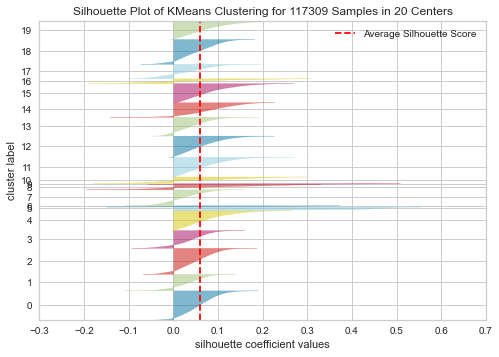

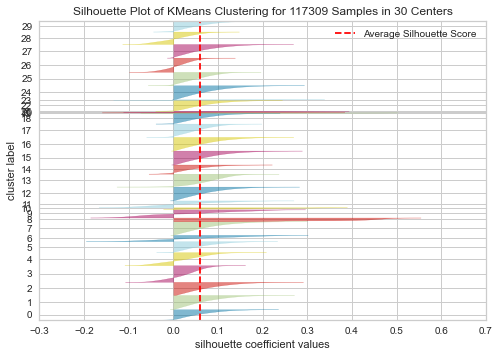

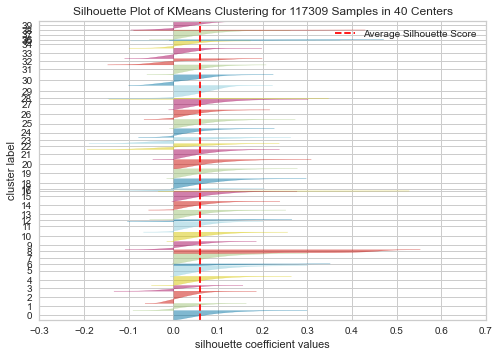

In [40]:
# fig, ax = plt.subplots(2, 2, figsize=(15,10))
for i in [10, 20, 30, 40]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(X)
    visualizer.show()
# fig.show()

We can see that clusters have even sizes when we put k = 30.

We will now try to find the best model with 30 clusters.

## Finding the best model with k = 30

random state = 40


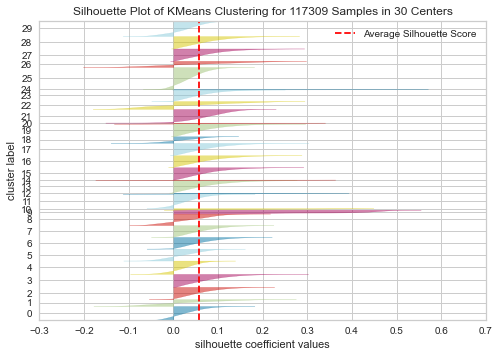

random state = 41


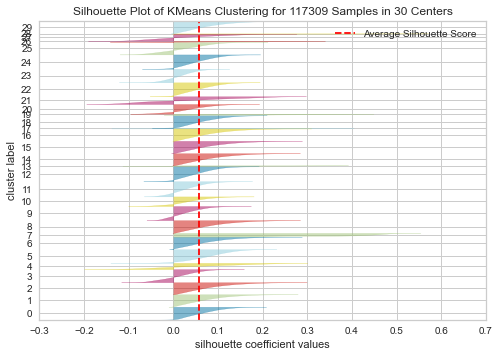

random state = 42


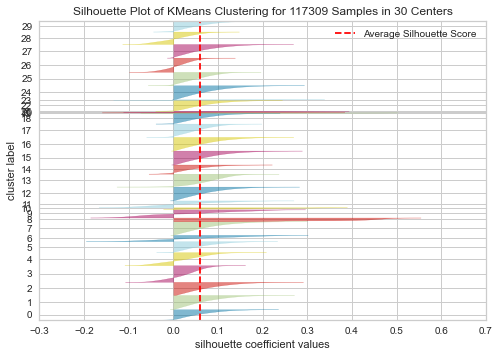

random state = 43


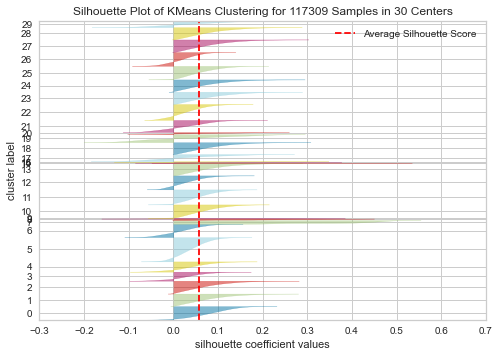

In [41]:
j = 40
for i in [40, 41, 42, 43]:
    km = KMeans(n_clusters=30, init='k-means++', n_init=10, max_iter=100, random_state=i)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(X)
    print("random state = " + str(j))
    j += 1
    visualizer.show()

The best random state is 42.

## Model Fitting

In [24]:
k = 30
kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

## Clusters Visualisation

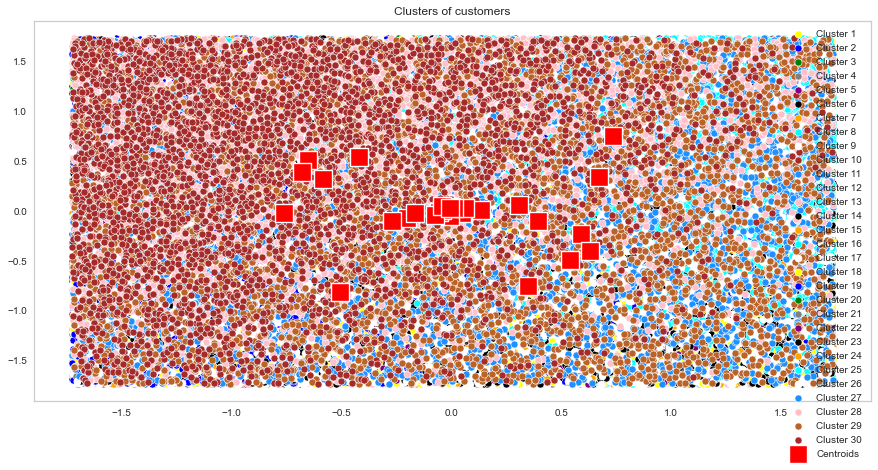

In [43]:
plt.figure(figsize=(15,7))
sns.scatterplot(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], color = 'yellow', label = 'Cluster 1',s=50)
sns.scatterplot(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], color = 'blue', label = 'Cluster 2',s=50)
sns.scatterplot(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], color = 'green', label = 'Cluster 3',s=50)
sns.scatterplot(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], color = 'grey', label = 'Cluster 4',s=50)
sns.scatterplot(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], color = 'purple', label = 'Cluster 5',s=50)
sns.scatterplot(X[y_kmeans == 5, 0], X[y_kmeans == 5, 1], color = 'black', label = 'Cluster 6',s=50)
sns.scatterplot(X[y_kmeans == 6, 0], X[y_kmeans == 6, 1], color = 'orange', label = 'Cluster 7',s=50)
sns.scatterplot(X[y_kmeans == 7, 0], X[y_kmeans == 7, 1], color = 'cyan', label = 'Cluster 8',s=50)
sns.scatterplot(X[y_kmeans == 8, 0], X[y_kmeans == 8, 1], color = 'white', label = 'Cluster 9',s=50)
sns.scatterplot(X[y_kmeans == 9, 0], X[y_kmeans == 9, 1], color = 'brown', label = 'Cluster 10',s=50)
sns.scatterplot(X[y_kmeans == 10, 0], X[y_kmeans == 10, 1], color = 'dodgerblue', label = 'Cluster 11',s=50)
sns.scatterplot(X[y_kmeans == 11, 0], X[y_kmeans == 11, 1], color = '#bb6229', label = 'Cluster 12',s=50)
sns.scatterplot(X[y_kmeans == 12, 0], X[y_kmeans == 12, 1], color = 'pink', label = 'Cluster 13',s=50)
sns.scatterplot(X[y_kmeans == 13, 0], X[y_kmeans == 13, 1], color = 'black', label = 'Cluster 14',s=50)
sns.scatterplot(X[y_kmeans == 14, 0], X[y_kmeans == 14, 1], color = 'orange', label = 'Cluster 15',s=50)
sns.scatterplot(X[y_kmeans == 15, 0], X[y_kmeans == 15, 1], color = 'cyan', label = 'Cluster 16',s=50)
sns.scatterplot(X[y_kmeans == 16, 0], X[y_kmeans == 16, 1], color = 'white', label = 'Cluster 17',s=50)
sns.scatterplot(X[y_kmeans == 17, 0], X[y_kmeans == 17, 1], color = 'yellow', label = 'Cluster 18',s=50)
sns.scatterplot(X[y_kmeans == 18, 0], X[y_kmeans == 18, 1], color = 'blue', label = 'Cluster 19',s=50)
sns.scatterplot(X[y_kmeans == 19, 0], X[y_kmeans == 19, 1], color = 'green', label = 'Cluster 20',s=50)
sns.scatterplot(X[y_kmeans == 20, 0], X[y_kmeans == 20, 1], color = 'grey', label = 'Cluster 21',s=50)
sns.scatterplot(X[y_kmeans == 21, 0], X[y_kmeans == 21, 1], color = 'purple', label = 'Cluster 22',s=50)
sns.scatterplot(X[y_kmeans == 22, 0], X[y_kmeans == 22, 1], color = 'black', label = 'Cluster 23',s=50)
sns.scatterplot(X[y_kmeans == 23, 0], X[y_kmeans == 23, 1], color = 'orange', label = 'Cluster 24',s=50)
sns.scatterplot(X[y_kmeans == 24, 0], X[y_kmeans == 24, 1], color = 'cyan', label = 'Cluster 25',s=50)
sns.scatterplot(X[y_kmeans == 25, 0], X[y_kmeans == 25, 1], color = 'white', label = 'Cluster 26',s=50)
sns.scatterplot(X[y_kmeans == 26, 0], X[y_kmeans == 26, 1], color = 'dodgerblue', label = 'Cluster 27',s=50)
sns.scatterplot(X[y_kmeans == 27, 0], X[y_kmeans == 27, 1], color = 'pink', label = 'Cluster 28',s=50)
sns.scatterplot(X[y_kmeans == 28, 0], X[y_kmeans == 28, 1], color = '#bb6229', label = 'Cluster 29',s=50)
sns.scatterplot(X[y_kmeans == 29, 0], X[y_kmeans == 29, 1], color = 'brown', label = 'Cluster 30',s=50)
sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color = 'red', 
                label = 'Centroids',s=300,marker=',')
plt.grid(False)
plt.title('Clusters of customers')
plt.legend()
plt.show()

## Model Evaluation

In [25]:
kmeans_sc = silhouette_score(X, y_kmeans)
print("Silhouette Score: ", kmeans_sc)

Silhouette Score:  0.059872941951397515


The silhouette score tells us how close clusters are to each other and if some instances may have been clustered in the wrong category.

In [27]:
kmeans_ch = calinski_harabasz_score(X, kmeans.labels_)
print("CH Score: ", kmeans_ch)

CH Score:  3695.4177385055955


The CH index is used to measure the validity of the model , it is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters. The higher the result, the better.

In [26]:
kmeans_db = davies_bouldin_score(X, kmeans.labels_)
print("Davies Bouldin index: ", kmeans_db)

Davies Bouldin index:  2.163156841065274


The Davies Bouldin index is used to assess the similarity of the clusters. The lower its value is the better, because a DB index value close to 0 means that the clusters are dense and well separated. 

# DBScan

## Finding the best Epsilon

Epsilon found:  1.888842945280494


<Figure size 360x360 with 0 Axes>

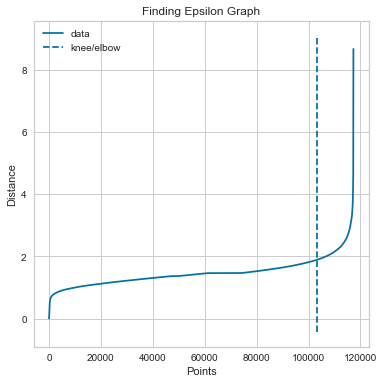

In [49]:
neighbors = NearestNeighbors(n_neighbors=40)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.title("Finding Epsilon Graph")
fig.show()
eps = distances[knee.knee]
print("Epsilon found: ", eps)

## Model Fitting

In [50]:
dbscan_cluster = DBSCAN(eps=eps, min_samples=40)
dbscan_cluster.fit(X)
db_fit = dbscan_cluster.fit_predict(X)

## Model Evaluation

In [51]:
dbscan_sc = silhouette_score(X, db_fit)
dbscan_ch = calinski_harabasz_score(X, dbscan_cluster.labels_)
dbscan_db = davies_bouldin_score(X, dbscan_cluster.labels_)
print("Silhouette Score: ", dbscan_sc)
print("CH Score: ", dbscan_ch)
print("Davies Bouldin index: ", dbscan_db)

Silhouette Score:  0.044606099736524706
CH Score:  4735.117632962065
Davies Bouldin index:  4.534223013510729


# Conclusion

We will now compare KMeans and DBScan on their scores.

In [53]:
scores = [["KMeans", kmeans_sc, kmeans_ch, kmeans_db ],["DBSCAN", dbscan_sc, dbscan_ch, dbscan_db]]
scores_df = pd.DataFrame(scores, columns = ["Model", "Silhouette score", "CH index", "DB index"])
scores_df = scores_df.sort_values(by = "Silhouette score",ascending=False)
scores_df

,Model,Silhouette score,CH index,DB index
0,KMeans,0.059873,3695.417739,2.163157
1,DBSCAN,0.044606,4735.117633,4.534223


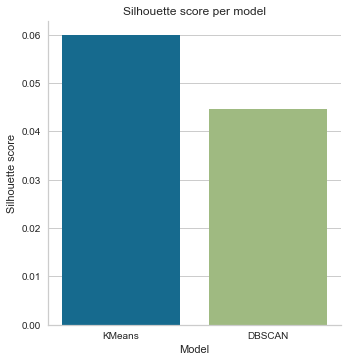

In [55]:
sns.catplot(data=scores_df, kind="bar",x ="Model", y="Silhouette score").set(title="Silhouette score per model")
plt.show()

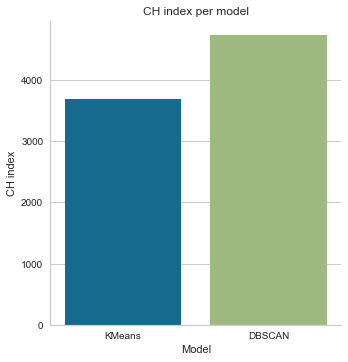

In [56]:
sns.catplot(data=scores_df, kind="bar",x ="Model", y="CH index").set(title="CH index per model")
plt.show()

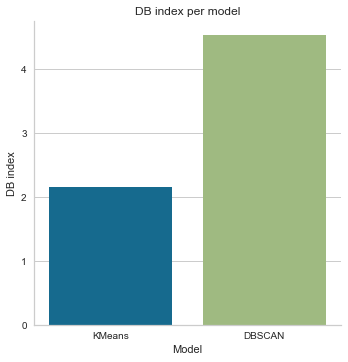

In [57]:
sns.catplot(data=scores_df, kind="bar",x ="Model", y="DB index").set(title="DB index per model")
plt.show()

* KMeans did better on the silhouette score.
* DBScan did better on the CH Index.
* DBScan did better on the DB Index.

In conclusion, all of our models did poorly.